<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/learn_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World's simplest convolvutional neural network
[Fayyaz Minhas](https://sites.google.com/view/fayyaz/)

## Filtering

## Filtering in Pytorch

## Can we make learnable filters?

sizes of images are: (512, 512) and (512, 512)


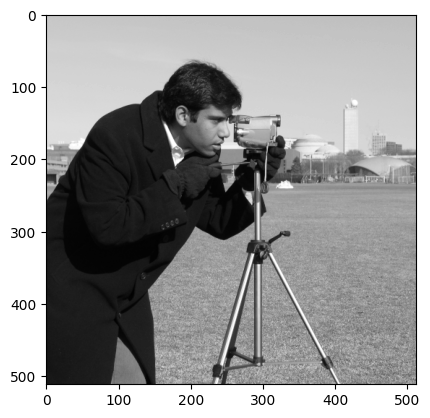

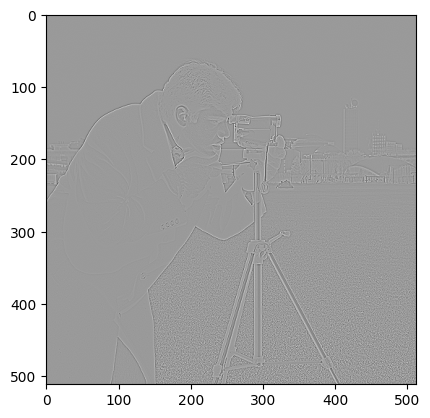

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from scipy.ndimage import convolve
K = np.array([[0,1,0],[1,-4,1],[0,1,0]])/4 # our filter. You can choose another one
I = camera()/255.0 #so that values are in the range 0-255
H = convolve(I,K)
plt.figure();plt.imshow(I,cmap='gray')
plt.figure();plt.imshow(H,cmap='gray')
print(f"sizes of images are: {I.shape} and {H.shape}")

Convolution filter of dimensions: torch.Size([1, 1, 3, 3])
sizes of images are: (512, 512) and (510, 510)


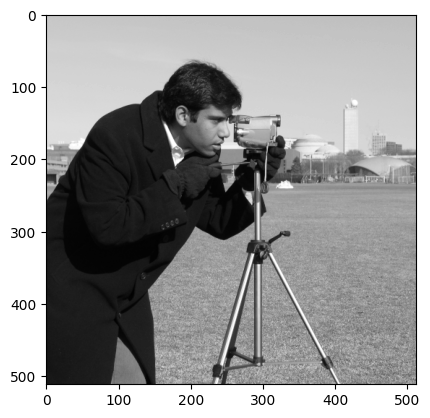

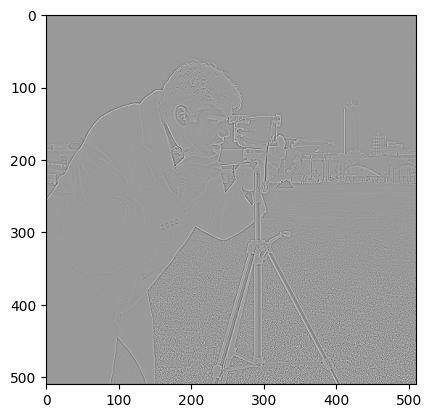

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class Filter(nn.Module):
    def __init__(self,K):
        super(Filter, self).__init__()
        K = torch.from_numpy(K).float()
        self.K = K.unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by padding two extra dimensions in the beginning
    def forward(self, x):
        return F.conv2d(x, self.K)
    def __repr__(self):
      return f"Convolution filter of dimensions: {self.K.shape}"

plt.close('all')
from skimage import data
X = data.camera()/255.0; plt.imshow(X,cmap='gray')
K = np.array([[0 ,1, 0],[1,-4,1], [0, 1 ,0]])/4.0
X_torch = torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by padding two extra dimensions in the beginning
#move image to torch
f = Filter(K)
#set the kernel in Filter object
Z_torch = f(X_torch)
#convolution
Z = Z_torch.squeeze().detach().numpy()
#move back to numpy
plt.figure();plt.imshow(Z,cmap='gray')
print(f)
print(f"sizes of images are: {X.shape} and {Z.shape}")

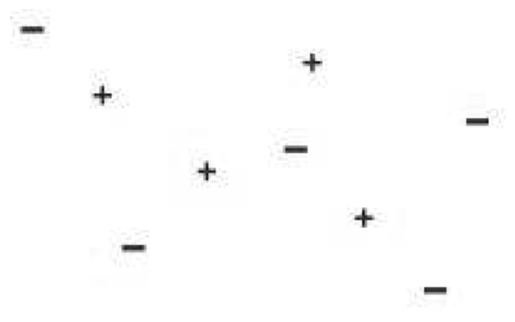

In [3]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
# URL of the raw image hosted on GitHub https://github.com/foxtrotmike/CS909/blob/master/in.jpg
image_url = 'https://raw.githubusercontent.com/foxtrotmike/CS909/master/in.jpg'
# Use requests to fetch the image
response = requests.get(image_url)
# Make sure the request was successful
if response.status_code == 200:
    # Open the image from the binary response content
    image = Image.open(BytesIO(response.content))
else:
    print("Failed to fetch image")
import matplotlib.pyplot as plt
# Display the image using matplotlib
plt.imshow(image,cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

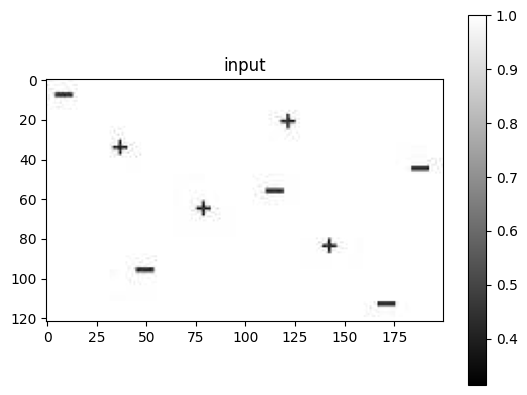

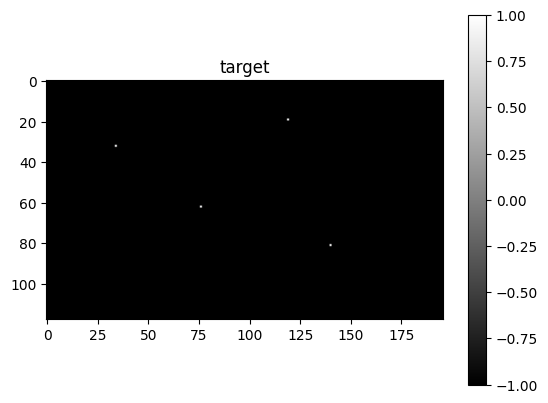

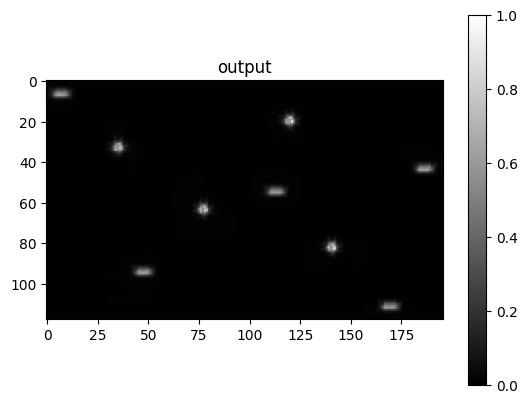

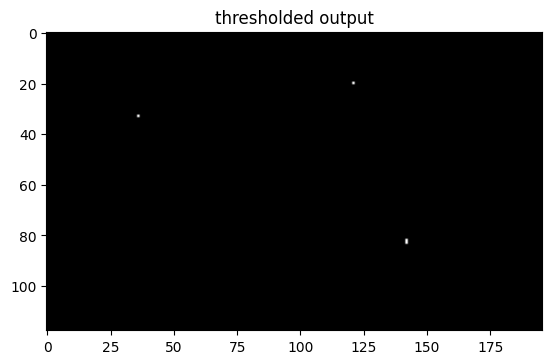

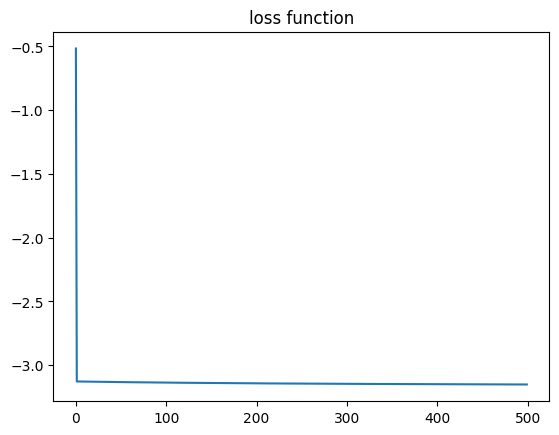

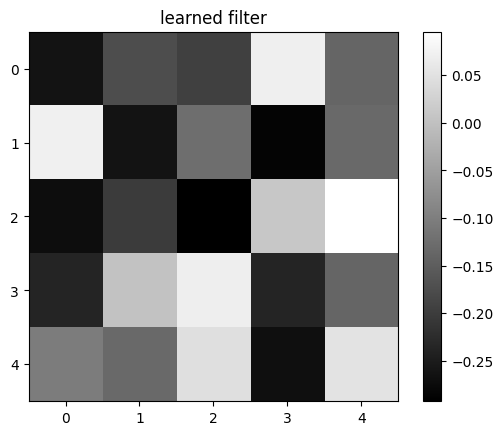

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
class Filter(nn.Module):
    def __init__(self, ksize = 3):
        super(Filter, self).__init__()
        self.conv1 = nn.Conv2d(1,1, ksize)
    def forward(self, x):
        x = self.conv1(x)
        return x


#import skimage
X = np.array(image)/255.0
#create the target by putting 1.0 at target object locations and -1 at others
T = -np.ones_like(X)
T[21,121]=1.0
T[34,36] =1.0
T[64,78] =1.0
T[83,142]=1.0
# let's use a convolution filter of size ksize
ksize = 5
bsize = int(ksize/2) #size of broder region
T = T[bsize:-bsize,bsize:-bsize] # reduce target filter size to compensate for border loss in convolution
f = Filter(ksize)
optimizer = torch.optim.SGD(f.parameters(), lr=1e-1)
T_torch = torch.from_numpy(T).float()
X_torch = torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by padding two extra dimensions in the beginning
L = []
for _ in range(500):
    Z_torch = f(X_torch).squeeze()
    Z_torch = torch.tanh(Z_torch) #output
    loss = torch.mean((T_torch-Z_torch)**2) #error
    optimizer.zero_grad() #optimization
    loss.backward()
    optimizer.step()
    L.append(loss.item())

output = Z_torch.squeeze().detach().numpy()
output = (output-np.min(output))/(np.max(output)-np.min(output)) #rescale
plt.figure();plt.imshow(X,cmap='gray');plt.title('input');plt.colorbar()
plt.figure();plt.imshow(T,cmap='gray');plt.title('target');plt.colorbar()
plt.figure();plt.imshow(output,cmap='gray');plt.title('output');plt.colorbar()
plt.figure();plt.imshow(output>0.8,cmap='gray');plt.title('thresholded output')
plt.figure();plt.plot(np.log10(L));plt.title('loss function')
plt.figure();plt.imshow(f.conv1.weight.squeeze().detach().numpy(),cmap='gray');plt.title('learned filter');plt.colorbar()